**Name:Isha Shrestha**
**NetID: is418**


Here, I am using the XGBClassifier with the best parameters, and then finding the most important features, giving around 80% accuracy.
Then, I am using a pipeline to transform the data, and retrain the model on the transformed data, again finding the most important features. It is giving 75% accuracy, which is actually lower. So, kind of surprising.

In [1]:
import pandas as pd
import numpy as np

In [2]:
passengers = pd.read_csv("titanic.csv",dtype={'Age': np.float64})

In [3]:
passengers = passengers.drop(labels=1309, axis = 0)

In [4]:
passengers.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [5]:
passengers.loc[passengers['embarked'].isnull(), 'embarked'] = 'U'

In [6]:
passengers.loc[passengers.age.isnull(), 'age'] = passengers.age.median()

In [7]:
passengers.loc[passengers['fare'].isnull(), 'fare'] = passengers.fare.median()

In [8]:
passengers.loc[passengers['cabin'].isnull(),'cabin']= "Unknown"

In [9]:
passengers = pd.get_dummies(passengers, columns=["sex"], prefix="sex")

In [10]:
passengers.survived=passengers.survived.astype(int)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
y_sex_incl = passengers.survived
analysis_features = ['pclass','age','fare', 'sex_female','sex_male','sibsp','parch']
X_sex_incl = passengers[analysis_features]
train_X_sex_incl, val_X_sex_incl, train_y_sex_incl, val_y_sex_incl = train_test_split(X_sex_incl, y_sex_incl,random_state = 1)


In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
!pip install xgboost

In [15]:
from xgboost import XGBClassifier

In [16]:
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel

In [29]:
import matplotlib.pyplot as plt

In [17]:
#Defining the parameters to search within
param_grid = {
'n_estimators': range(6, 10),
'max_depth': range(3, 8),
'learning_rate': [.2, .3, .4],
'colsample_bytree': [.7, .8, .9, 1]
}
#Specifying our classifier
xgb2 = XGBClassifier()
#Searching for the best parameters
g_search = GridSearchCV(estimator = xgb2, param_grid = param_grid,
cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)
#Fitting the model using best parameters found
g_search.fit(train_X_sex_incl, train_y_sex_incl)
#Printing the best parameters found
print(g_search.best_params_)

{'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 9}


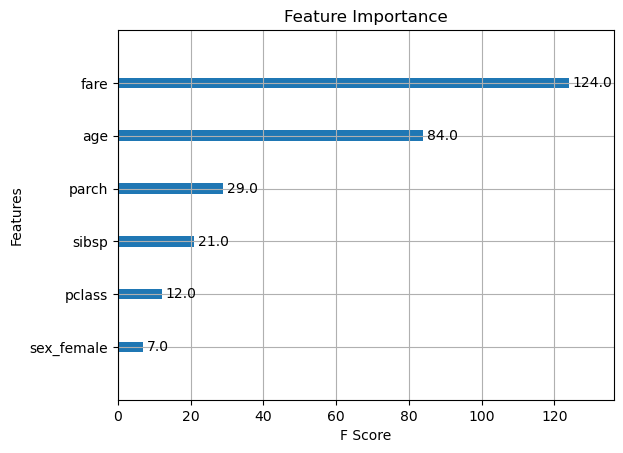

In [31]:
from xgboost import plot_importance
best_xgb = g_search.best_estimator_
booster = best_xgb.get_booster()
booster.feature_names = train_X_sex_incl.columns.tolist()  # Set the actual feature names

# Plot the feature importances with actual feature names
plot_importance(booster, importance_type='weight', title="Feature Importance", xlabel="F Score")
plt.show()

In [43]:
g_search.score(val_X_sex_incl,val_y_sex_incl)

0.801829268292683

In [33]:

pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('feature_selection', SelectFromModel(XGBClassifier(), threshold="mean")),
])




C:\Users\ishas\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


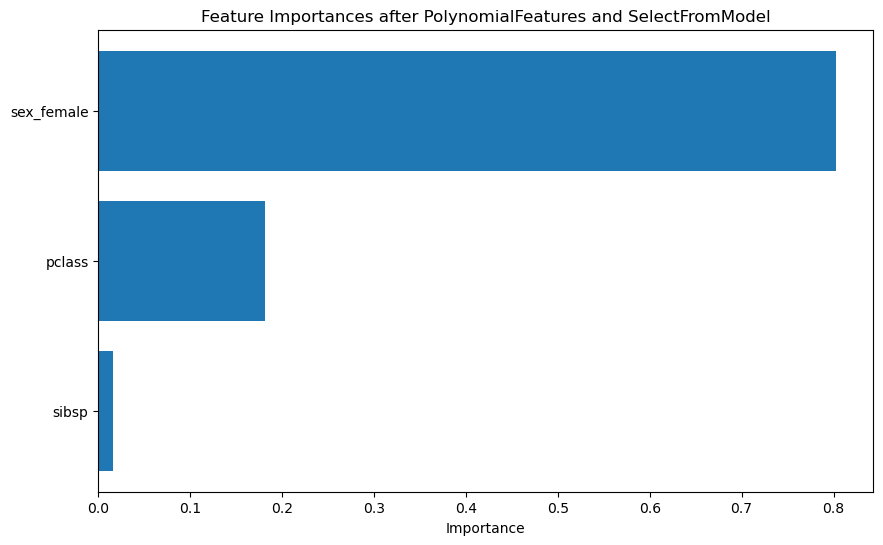

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Fit the entire pipeline on the training data
pipeline.fit(train_X_sex_incl, train_y_sex_incl)

# Step 2: Extract the transformed data after the entire pipeline (up to SelectFromModel)
transformed_data = pipeline.named_steps['poly'].transform(train_X_sex_incl)

# Step 3: Apply SelectFromModel to the transformed data
selected_train_X = pipeline.named_steps['feature_selection'].transform(transformed_data)

# Step 4: Retrain the XGBoost model on the selected features
xgb_model = XGBClassifier()
xgb_model.fit(selected_train_X, train_y_sex_incl)

# Step 5: Get feature importances for the selected features
feature_importances = xgb_model.feature_importances_

# Step 6: Extract the feature names after PolynomialFeatures transformation
poly_feature_names = pipeline.named_steps['poly'].get_feature_names_out(train_X_sex_incl.columns)

# Step 7: Get the names of the selected features based on the mask
selected_features_mask = pipeline.named_steps['feature_selection'].get_support()
selected_feature_names = np.array(poly_feature_names)[selected_features_mask]

# Step 8: Ensure the number of selected feature names matches the number of importances
if len(selected_feature_names) == len(feature_importances):
    # Step 9: Create a DataFrame to store feature names and their importances
    feature_importances_df = pd.DataFrame({
        'Feature': selected_feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Step 10: Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importances after PolynomialFeatures and SelectFromModel')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()

else:
    print(f"Feature count mismatch: {len(selected_feature_names)} selected features vs. {len(feature_importances)} feature importances.")


In [63]:
from sklearn.metrics import accuracy_score

In [65]:
# Step 1: Extract the important features from the original dataset
important_features = ['pclass', 'sex_female', 'sibsp']
train_X_important = train_X_sex_incl[important_features]
val_X_important = val_X_sex_incl[important_features]

# Step 2: Split the original training data into training and validation sets (if not done already)
train_X_imp, val_X_imp, train_y_imp, val_y_imp = train_test_split(train_X_important, train_y_sex_incl, test_size=0.2, random_state=42)

# Step 3: Train a new XGBoost model on the reduced dataset
xgb_model = XGBClassifier()
xgb_model.fit(train_X_imp, train_y_imp)

# Step 4: Make predictions on the validation set
val_y_pred = xgb_model.predict(val_X_imp)

# Step 5: Calculate and print the accuracy
accuracy = accuracy_score(val_y_imp, val_y_pred)
print(f"Accuracy with the three important features: {accuracy:.4f}")



Accuracy with the three important features: 0.7563
